# Applying the model
In this notebook, we will do a few things:
1. Plot the A13 highway from Rotterdam to Delft on November 7th between 8:00 and 10:00.
2. Find the MSI information of this highway during that time
3. Model the FRs in the domain
4. Compare the model, and the actual highway data
5. Add an alteration to the highway and compare with the original highway.

## 1. Plotting the historic data

In [1]:
# Settings
data_name = "a13_2_months"
starttime = "2023-11-07 08:00:00"
endtime = "2023-11-07 10:00:00"
direction = "R"
xnum = 100
tnum = 3600

In [2]:
import numpy as np
import pandas as pd
import torch

In [3]:
# Load a13 data
df = torch.load("df_"+data_name+".pth")

In [4]:
# Filter only a specific time-window
df = df[(df.start >= pd.to_datetime(starttime)) & (df.start <= pd.to_datetime(endtime))]

In [5]:
# Add direction and hectometer information
direction_dict = {}
hectometer_dict = {}
for i in df.id_meetlocatie.unique():
    if i[6:13] == "MONIBAS":
        if i[14:18] == "0131":
            direction_dict[i] = i[20].upper()
            hectometer_dict[i] = int(i[21:25]) / 10
    else:
        raise NameError(f"Please clarify id {i}")

df.loc[:, "direction"] = df["id_meetlocatie"].map(direction_dict)
df.loc[:, "hectometer"] = df["id_meetlocatie"].map(hectometer_dict)
df = df[df["direction"] == direction]

In [6]:
# Create density matrix of specific domain
times = df.start.unique()
hectometers = df.hectometer.unique()
density = np.zeros((len(times), len(hectometers)))
for i in range(len(times)):
    for j in range(len(hectometers)):
        try:
            density[i, j] = df[
                (df["start"] == times[i]) & 
                (df["hectometer"] == hectometers[j])
                ]["gem_dichtheid"].values[0]
        except IndexError:
            print("instance contained 0 cars:", times[i], "at hectometer", hectometers[j])
            pass

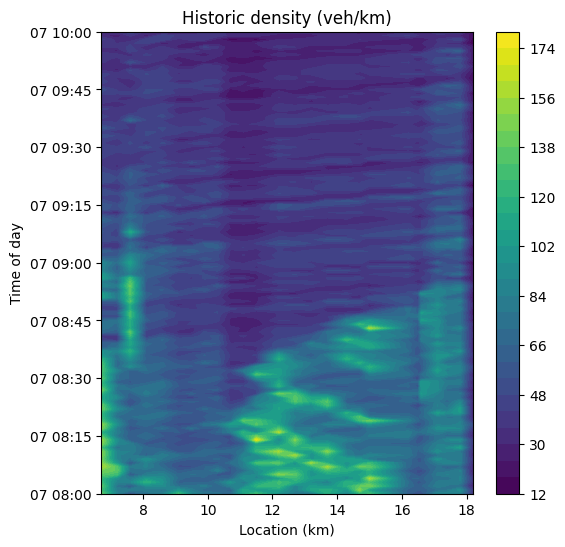

In [7]:
# Plot density matrix
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

fig,ax=plt.subplots(1,1, figsize=(6, 6))
X, Y = np.meshgrid(hectometers, times)
cp = ax.contourf(X, Y, density, levels=30)
fig.colorbar(cp)
plt.xlabel("Location (km)")
plt.ylabel("Time of day")
plt.title("Historic density (veh/km)")
plt.show()

## 2. Finding the MSI data in the domain

In [8]:
# Setting space domain
xmin = min(hectometers)
xmax = max(hectometers)

x = np.linspace(xmin, xmax, xnum)
x_boundaries = x + (x[1]- x[0])/2
x_boundaries = x_boundaries[:-1]

In [9]:
# Setting up time-domain and MSI information matrix
tmin = 0  # This is 8:00
tmax = (pd.to_datetime(endtime) - pd.to_datetime(starttime)) / np.timedelta64(1, 'h')  # This is 10:00. All variables are in km - hr - #cars
t = np.linspace(tmin, tmax, tnum)
t_df = pd.DataFrame()
t_df["start"] = pd.to_datetime(t*3600000000000 + pd.to_datetime(starttime).value)

MSI_information = np.zeros((tnum, xnum, 6))

In [10]:
def add_MSI_information(IS_loc_df, MSI_df, hectometer, direction, max_speed=100.0, num_lanes=6):
    # In this function, IS_loc_df is the subset of IS_df with only the data of 1 location. 
    # We will create num_lanes=6 empty columns of return_df, with the same number of rows as loc_df
    return_df = pd.DataFrame()

    # Find closest location, call it "closest_measuring_location"
    dir_df = MSI_df[MSI_df["DVK"] == direction]
    hm_points = dir_df.Hectometrering.unique()
    try:
        if direction == "R": 
            closest_measuring_location = max(hm_points[hm_points <= hectometer])
        else:
            closest_measuring_location = min(hm_points[hm_points >= hectometer])
    except ValueError:
        print(f'ERROR: Matrix data unknown for measuring point {IS_loc_df["id_meetlocatie"].unique()[0]}\nat hectometer {hectometer}, direction {direction}.\nTry adding more MSI data.')
        for lane_nr in range(1, num_lanes+1):
            return_df[lane_nr] = [0] * len(IS_loc_df)
        return return_df
        # raise ValueError(f"Matrix data unknown for measuring point at hectometer {hectometer}.\nTry adding more MSI data.")
    # Only look at the closest location
    loc_df = dir_df[dir_df["Hectometrering"] == closest_measuring_location]
    # print(loc_df)
    # Define MSI configs:
    MSIconfigs = {
        "blank": max_speed,
        "lane_closed_ahead merge_left": max_speed,
        "lane_closed_ahead merge_right": max_speed,
        "restriction_end": max_speed,
        "lane_closed": 0,
        "speedlimit 100": 100,
        "speedlimit 90": 90,
        "speedlimit 80": 80,
        "speedlimit 70": 70,
        "speedlimit 60": 60, 
        "speedlimit 50": 50,
        "speedlimit 30": 30,
        "unknown": max_speed
    }

    for lane_nr in range(1, num_lanes+1):
        # If there is no lane_nr in the closest location, then there is no lane. 
        # Set max speed equal to 0 for the whole time on this lane
        lane_df = loc_df[loc_df["Rijstrook"] == lane_nr]
        if lane_df.empty:
            return_df[lane_nr] = [0] * len(IS_loc_df)
            continue
                
        # Now, for every row in IS_loc_df, find the latest update time
        change_times = lane_df.time
        last_update_time = change_times.iloc[0]
        last_update = MSIconfigs[lane_df[change_times == last_update_time]["Beeldstand"].values[0]]
        next_update_time = change_times.iloc[1]
        column = []
        for measure_time in IS_loc_df["start"]:
            if measure_time < next_update_time:
                column.append(last_update)
            else:
                last_update_time = max(lane_df[change_times <= measure_time].time)
                last_update = MSIconfigs[lane_df[change_times == last_update_time]["Beeldstand"].values[0]]
                next_times = lane_df[change_times > measure_time].time
                if next_times.empty:
                    next_update_time = max(IS_loc_df.start)
                else:
                    next_update_time = min(next_times)
                column.append(last_update)
            # beeldstand = lane_df[change_times == latest_update_time]["Beeldstand"].values[0]
            # column.append(MSIconfigs[beeldstand])
        return_df[lane_nr] = column
    return return_df

In [11]:
from godunovfunctions import *

In [12]:
# Load MSI file
datafolder = os.path.join(os.path.dirname(os.getcwd()), "data", data_name)
datafolder_msi = os.path.join(datafolder, "msi-export")
msi_path = os.path.join(datafolder_msi, "msi-export.csv")

MSI_df = pd.read_csv(msi_path, low_memory=False)
MSI_df["time"] = pd.to_datetime(MSI_df["Datum en tijd beeldstandwijziging"])

In [13]:
# Loop over locations and add MSI information into the matrix
for i in tqdm.tqdm(range(len(x))):
    hectometer = x[i]
    IS_loc_df = pd.DataFrame()
    ret = add_MSI_information(t_df, MSI_df, hectometer=hectometer, direction=direction)
    MSI_information[:, i, :] = ret

100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


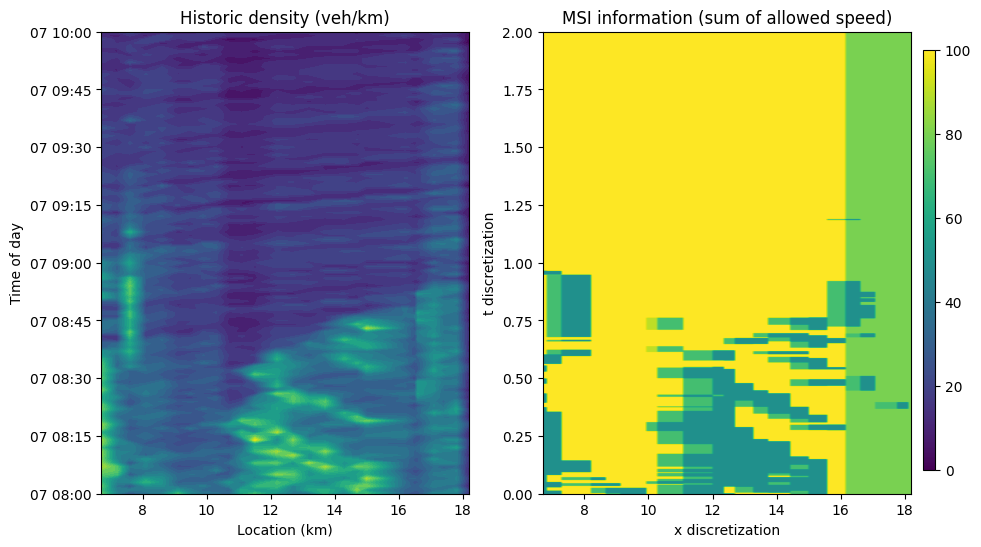

In [38]:
# Plot MSI information next to density
fig,ax=plt.subplots(1,2, figsize=(12, 6))
X, Y = np.meshgrid(hectometers, times)
cb1 = ax[0].contourf(X, Y, density, levels=30)
ax[0].set(xlabel="Location (km)", ylabel="Time of day", title="Historic density (veh/km)" )
# fig.colorbar(cb1, ax[0])


cb2 = ax[1].imshow(MSI_information[:, :, 0], origin="lower",  aspect='auto', extent=(xmin, xmax, tmin, tmax), vmin=0, vmax=100)
# cb2 = ax[1].imshow(np.sum(MSI_information, axis=2), origin="lower", aspect="auto", extent=(xmin, xmax, tmin, tmax))
ax[1].set(xlabel="x discretization", ylabel='t discretization', title="MSI information (sum of allowed speed)")
# fig.colorbar(cb2, ax[1])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.01, 0.7])
fig.colorbar(cb2, cax=cbar_ax)
plt.show()


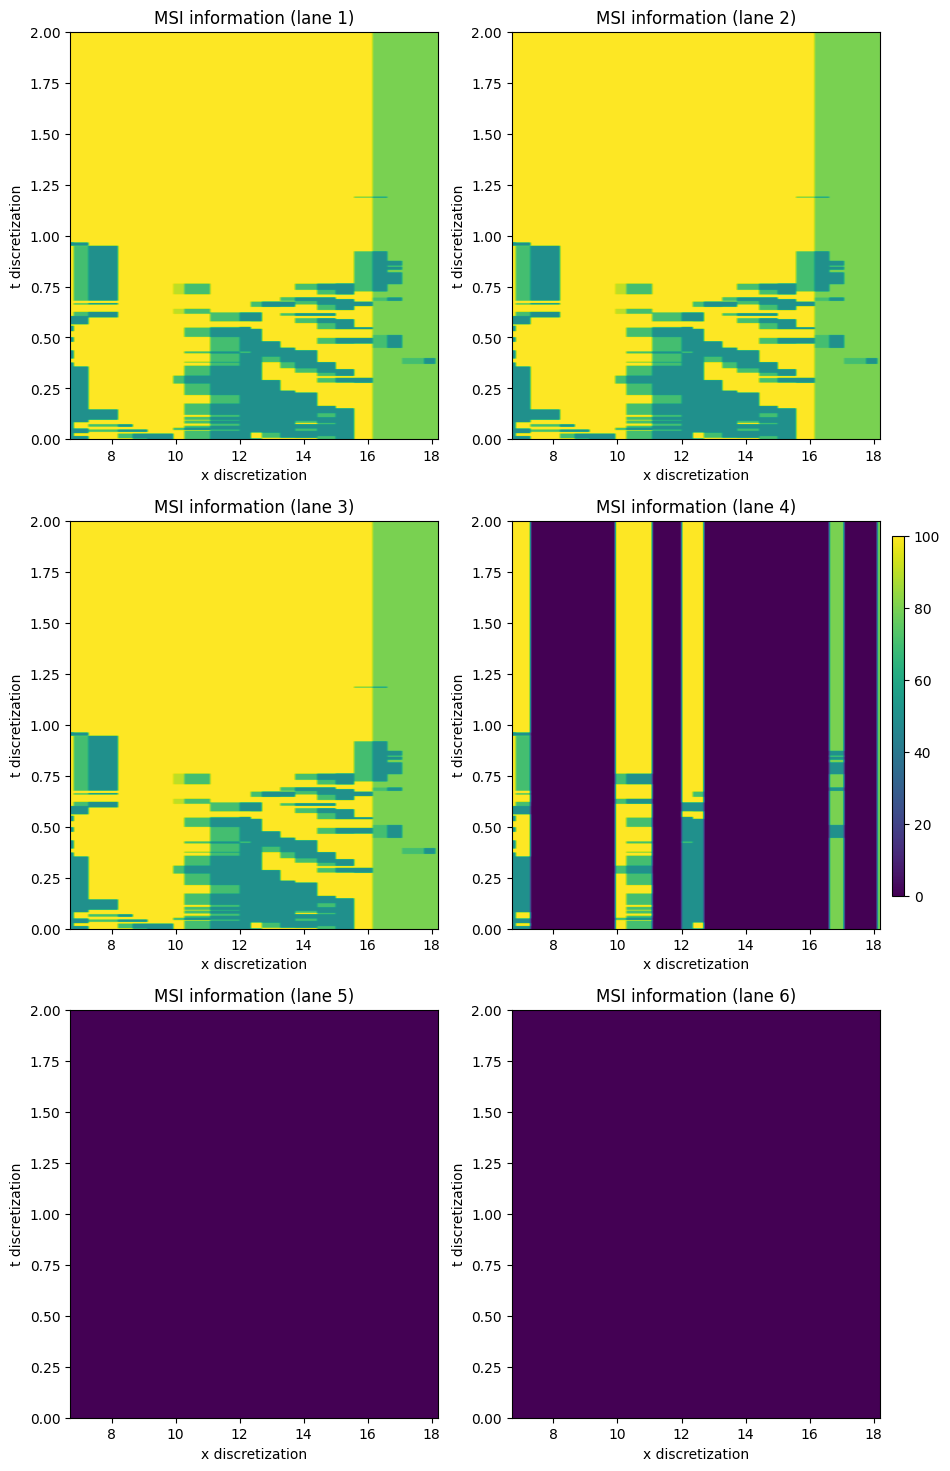

In [36]:
# Plot ALL MSI data
fig,ax=plt.subplots(3,2, figsize=(12, 18))

cb2 = ax[0, 0].imshow(MSI_information[:, :, 0], origin="lower", aspect="auto", extent=(xmin, xmax, tmin, tmax), vmin=0, vmax=100)
ax[0, 0].set(xlabel="x discretization", ylabel='t discretization', title="MSI information (lane 1)")

cb2 = ax[0, 1].imshow(MSI_information[:, :, 1], origin="lower", aspect="auto", extent=(xmin, xmax, tmin, tmax), vmin=0, vmax=100)
ax[0, 1].set(xlabel="x discretization", ylabel='t discretization', title="MSI information (lane 2)")

cb2 = ax[1, 0].imshow(MSI_information[:, :, 2], origin="lower", aspect="auto", extent=(xmin, xmax, tmin, tmax), vmin=0, vmax=100)
ax[1, 0].set(xlabel="x discretization", ylabel='t discretization', title="MSI information (lane 3)")

cb2 = ax[1, 1].imshow(MSI_information[:, :, 3], origin="lower", aspect="auto", extent=(xmin, xmax, tmin, tmax), vmin=0, vmax=100)
ax[1, 1].set(xlabel="x discretization", ylabel='t discretization', title="MSI information (lane 4)")

cb2 = ax[2, 0].imshow(MSI_information[:, :, 4], origin="lower", aspect="auto", extent=(xmin, xmax, tmin, tmax), vmin=0, vmax=100)
ax[2, 0].set(xlabel="x discretization", ylabel='t discretization', title="MSI information (lane 5)")

cb2 = ax[2, 1].imshow(MSI_information[:, :, 5], origin="lower", aspect="auto", extent=(xmin, xmax, tmin, tmax), vmin=0, vmax=100)
ax[2, 1].set(xlabel="x discretization", ylabel='t discretization', title="MSI information (lane 6)")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.4, 0.01, 0.2])
fig.colorbar(cb2, cax=cbar_ax)
plt.show()

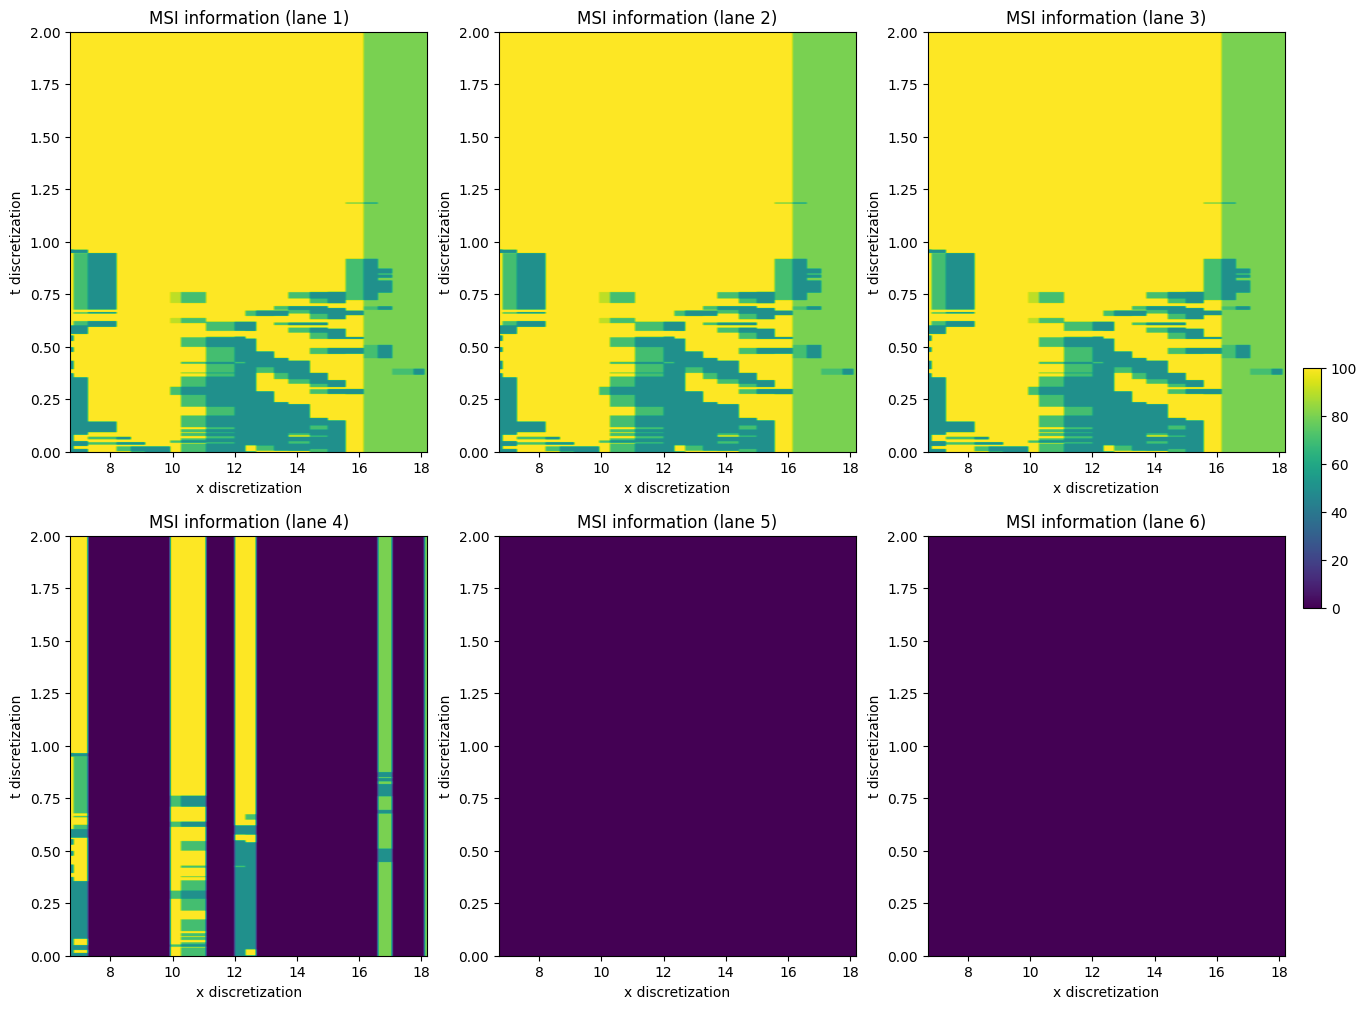

In [40]:
# Plot ALL MSI data
fig,ax=plt.subplots(2,3, figsize=(18, 12))

cb2 = ax[0, 0].imshow(MSI_information[:, :, 0], origin="lower", aspect="auto", extent=(xmin, xmax, tmin, tmax), vmin=0, vmax=100)
ax[0, 0].set(xlabel="x discretization", ylabel='t discretization', title="MSI information (lane 1)")

cb2 = ax[0, 1].imshow(MSI_information[:, :, 1], origin="lower", aspect="auto", extent=(xmin, xmax, tmin, tmax), vmin=0, vmax=100)
ax[0, 1].set(xlabel="x discretization", ylabel='t discretization', title="MSI information (lane 2)")

cb2 = ax[0, 2].imshow(MSI_information[:, :, 2], origin="lower", aspect="auto", extent=(xmin, xmax, tmin, tmax), vmin=0, vmax=100)
ax[0, 2].set(xlabel="x discretization", ylabel='t discretization', title="MSI information (lane 3)")

cb2 = ax[1, 0].imshow(MSI_information[:, :, 3], origin="lower", aspect="auto", extent=(xmin, xmax, tmin, tmax), vmin=0, vmax=100)
ax[1, 0].set(xlabel="x discretization", ylabel='t discretization', title="MSI information (lane 4)")

cb2 = ax[1, 1].imshow(MSI_information[:, :, 4], origin="lower", aspect="auto", extent=(xmin, xmax, tmin, tmax), vmin=0, vmax=100)
ax[1, 1].set(xlabel="x discretization", ylabel='t discretization', title="MSI information (lane 5)")

cb2 = ax[1, 2].imshow(MSI_information[:, :, 5], origin="lower", aspect="auto", extent=(xmin, xmax, tmin, tmax), vmin=0, vmax=100)
ax[1, 2].set(xlabel="x discretization", ylabel='t discretization', title="MSI information (lane 6)")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.4, 0.01, 0.2])
fig.colorbar(cb2, cax=cbar_ax)
plt.show()

## 3. Run Godunov scheme in the domain

In [41]:
# Set up road layout object
RL = RoadLayout(x)

In [42]:
# Find initial density and boundary condition
q_initial = np.interp(x, hectometers, density[0])

times_as_num = (times - pd.to_datetime(starttime)) / np.timedelta64(1, 'h')
q_boundary = np.interp(t, times_as_num, density[:, 0])


In [43]:
# Initialize neural network
model = torch.load("a13_2_months_MODEL.pth")

In [44]:
# Set up Godunov scheme object
GS = GodunovScheme(
    road_layout=RL,
    q=q_initial,
    fr=Smulders(),
)

In [45]:
# Time loop
density_model = np.zeros((len(t), len(x)))
density_model[0] = q_initial

for i in tqdm.tqdm(range(len(t)-1)):
    # Update FRs
    input_array = np.concatenate((MSI_information[i, :-1, :], q_initial[:-1, np.newaxis]), axis=1) / 100
    with torch.no_grad():
        input_tensor = torch.tensor(input_array, dtype=torch.float32)
        FR_params = model.get_params(input_tensor).numpy() * 100
    FR_list = [Smulders(*param_set) for param_set in FR_params]
    GS.fr = FR_list 

    # Perform time-step
    GS.time_step(dt=t[i+1]-t[i])

    # Update BC
    GS.q[0] = q_boundary[i+1]

    # Save density result
    density_model[i+1] = GS.q


  0%|          | 0/3599 [00:00<?, ?it/s]

100%|██████████| 3599/3599 [00:05<00:00, 652.40it/s]


## 4. Compare the model, and the actual highway data


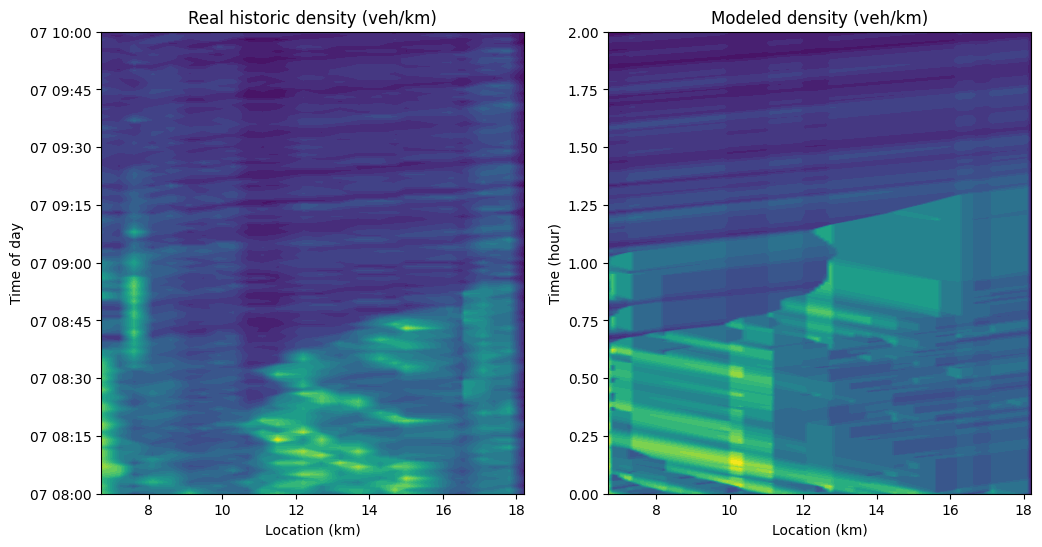

In [46]:
# Plot MSI information
fig,ax=plt.subplots(1,2, figsize=(12, 6))
X, Y = np.meshgrid(hectometers, times)
cp = ax[0].contourf(X, Y, density, levels=30)
ax[0].set(xlabel="Location (km)", ylabel="Time of day", title="Real historic density (veh/km)" )

# ax[1].imshow(MSI_information[:, :, 0], origin="lower",  aspect='auto', extent=(xmin, xmax, tmin, tmax))
# ax[1].set(xlabel="x discretization", ylabel='t discretization', title="MSI information (sum of allowed speed)")

X, Y = np.meshgrid(x, t)
cp = ax[1].contourf(X, Y, density_model, levels=30)
ax[1].set(xlabel="Location (km)", ylabel="Time (hour)", title="Modeled density (veh/km)" )

plt.show()

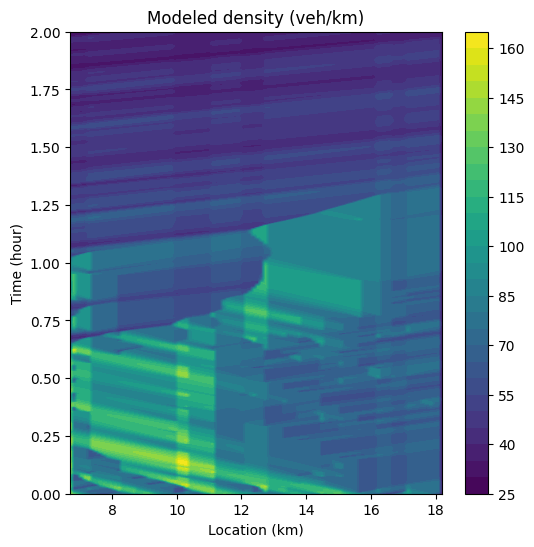

In [48]:
# Plot MSI information
fig,ax=plt.subplots(1,1, figsize=(6, 6))

X, Y = np.meshgrid(x, t)
cp = ax.contourf(X, Y, density_model, levels=30)
ax.set(xlabel="Location (km)", ylabel="Time (hour)", title="Modeled density (veh/km)" )
fig.colorbar(cp)

plt.show()

##  5. Add an alteration to the highway and compare results

In [21]:
# Congestion settings
alt_t_start = int(tnum*0.25)
alt_t_end = int(tnum*0.75)
alt_x_start = int(xnum*0.6)
alt_x_end = int(xnum*0.8)
alt_MSI = [50, 50, 0, 0, 0, 0]

In [22]:
# Create altered_MSI_information
altered_MSI_information = MSI_information.copy()
altered_MSI_information[alt_t_start:alt_t_end, alt_x_start:alt_x_end, :] = [[alt_MSI] * (alt_x_end - alt_x_start)] * (alt_t_end - alt_t_start)

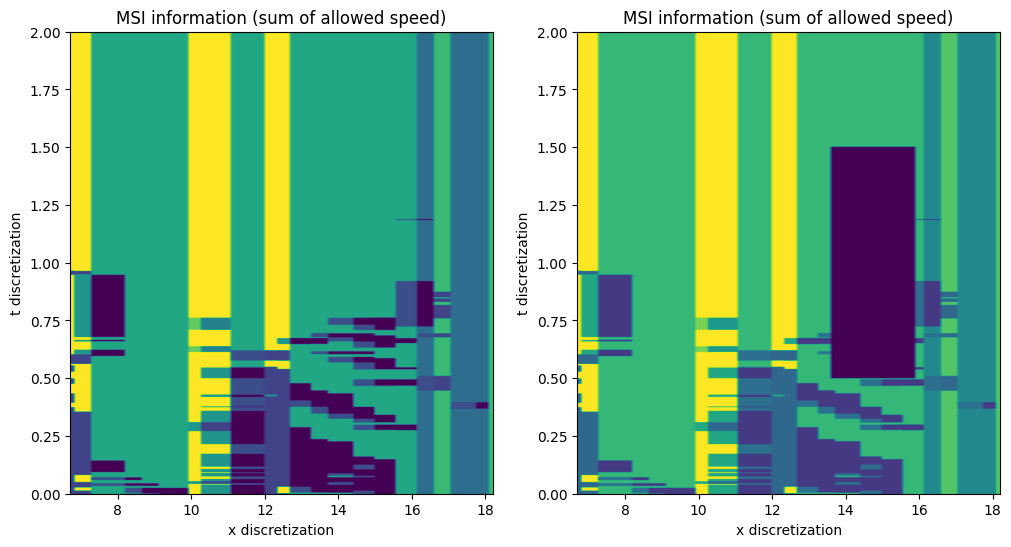

In [23]:
# Plot comparison between MSI information
fig,ax=plt.subplots(1,2, figsize=(12, 6))

# ax[1].imshow(np.sum(MSI_information, axis=2), origin="lower",  aspect='auto', extent=(xmin, xmax, tmin, tmax))
cb1 = ax[0].imshow(np.sum(MSI_information, axis=2), origin="lower", aspect="auto", extent=(xmin, xmax, tmin, tmax))
ax[0].set(xlabel="x discretization", ylabel='t discretization', title="MSI information (sum of allowed speed)")

# ax[1].imshow(np.sum(MSI_information, axis=2), origin="lower",  aspect='auto', extent=(xmin, xmax, tmin, tmax))
cb2 = ax[1].imshow(np.sum(altered_MSI_information, axis=2), origin="lower", aspect="auto", extent=(xmin, xmax, tmin, tmax))
ax[1].set(xlabel="x discretization", ylabel='t discretization', title="MSI information (sum of allowed speed)")
plt.show()

In [24]:
# Set up Godunov scheme object
GS_altered = GodunovScheme(
    road_layout=RL,
    q=q_initial,
    fr=Smulders(),
)

In [25]:
# Time loop
density_model_altered = np.zeros((len(t), len(x)))
density_model_altered[0] = q_initial

for i in tqdm.tqdm(range(len(t)-1)):
    # Update FRs
    input_array = np.concatenate((altered_MSI_information[i, :-1, :], q_initial[:-1, np.newaxis]), axis=1) / 100
    with torch.no_grad():
        input_tensor = torch.tensor(input_array, dtype=torch.float32)
        FR_params = model.get_params(input_tensor).numpy() * 100
    FR_list = [Smulders(*param_set) for param_set in FR_params]
    GS_altered.fr = FR_list 

    # Perform time-step
    GS_altered.time_step(dt=t[i+1]-t[i])

    # Update BC
    GS_altered.q[0] = q_boundary[i+1]

    # Save density result
    density_model_altered[i+1] = GS_altered.q

100%|██████████| 3599/3599 [00:05<00:00, 673.75it/s]


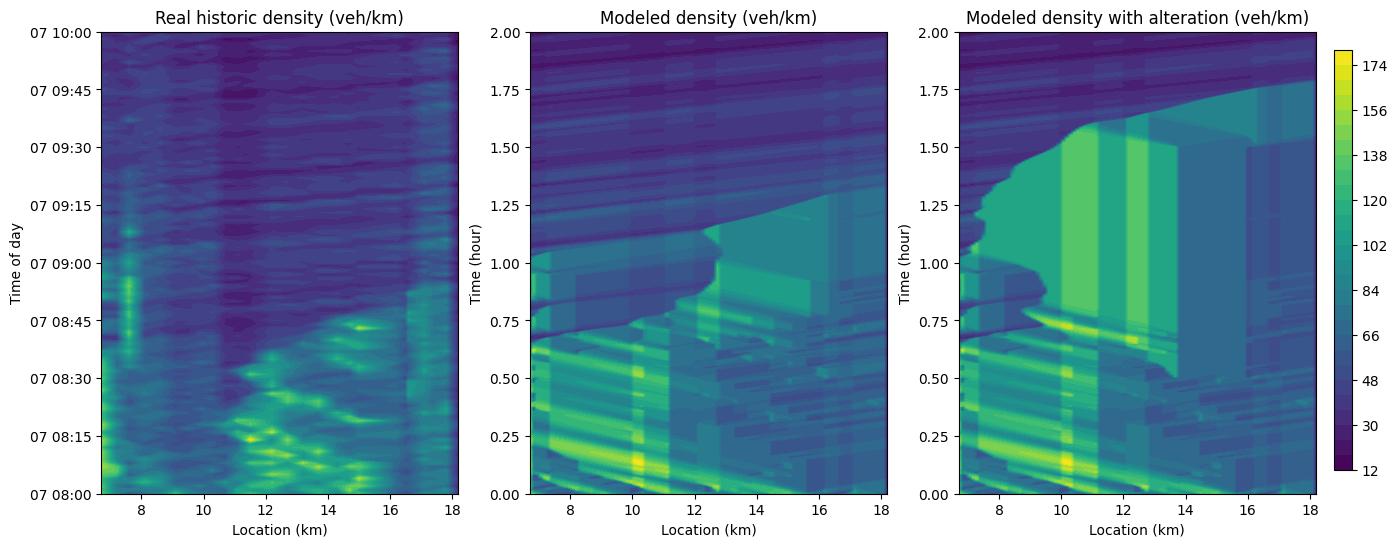

In [26]:
# Plot MSI information
fig,ax=plt.subplots(1,3, figsize=(18, 6))
X, Y = np.meshgrid(hectometers, times)
cp1 = ax[0].contourf(X, Y, density, levels=30)
ax[0].set(xlabel="Location (km)", ylabel="Time of day", title="Real historic density (veh/km)" )

# ax[1].imshow(MSI_information[:, :, 0], origin="lower",  aspect='auto', extent=(xmin, xmax, tmin, tmax))
# ax[1].set(xlabel="x discretization", ylabel='t discretization', title="MSI information (sum of allowed speed)")

X, Y = np.meshgrid(x, t)
cp2 = ax[1].contourf(X, Y, density_model, levels=30)
ax[1].set(xlabel="Location (km)", ylabel="Time (hour)", title="Modeled density (veh/km)" )

X, Y = np.meshgrid(x, t)
cp3 = ax[2].contourf(X, Y, density_model_altered, levels=30)
ax[2].set(xlabel="Location (km)", ylabel="Time (hour)", title="Modeled density with alteration (veh/km)" )

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.01, 0.7])
fig.colorbar(cp1, cax=cbar_ax)
plt.show()